In [1]:
dataset_name = "ec2_cpu_utilization_ac20cd"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '5min', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '5min', data, method="linear")

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="5min", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-04-15 00:49:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-04-02 14:29:00
End date:  2014-04-16 14:49:00
Missing time stamps: 
 DatetimeIndex(['2014-04-07 13:39:00', '2014-04-07 13:44:00',
               '2014-04-14 23:49:00', '2014-04-14 23:54:00',
               '2014-04-14 23:59:00'],
              dtype='datetime64[ns]', freq=None)
Fill Missing Time Steps with Interpolation
Length:  4037
Time step size:  5min
Start Date:  2014-04-02 14:29:00
End Date:  2014-04-16 14:49:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [3580]


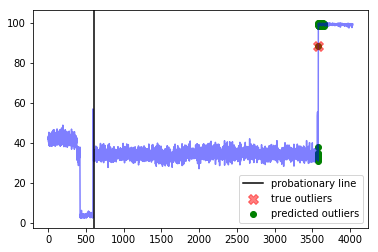

In [4]:
# for DMKD paper (does RNN really suck?)
ad.plot_outliers([3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3648, 3649, 3650, 3652, 3653, 3654],[3580])

# SARIMA: using autoarima

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=3202.652, BIC=3229.073, Fit time=0.205 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=3321.581, BIC=3330.388, Fit time=0.090 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=3222.387, BIC=3235.598, Fit time=0.172 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=3197.130, BIC=3210.341, Fit time=0.273 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=3198.860, BIC=3216.475, Fit time=0.240 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=3198.802, BIC=3216.417, Fit time=0.303 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=3201.127, BIC=3223.145, Fit time=0.532 seconds
Total fit time: 1.876 seconds
Final parameters:  (0, 1, 1, 0, 0, 0, 0)


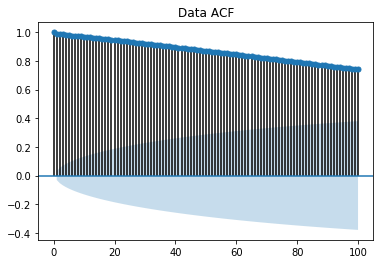

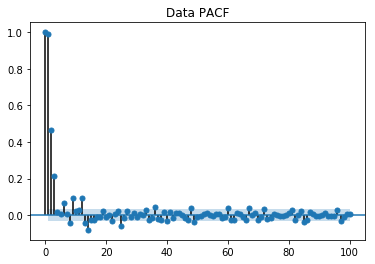

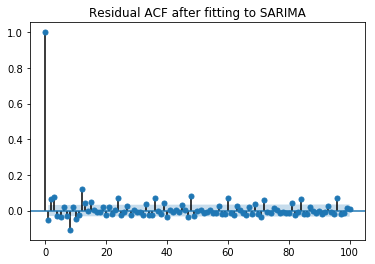

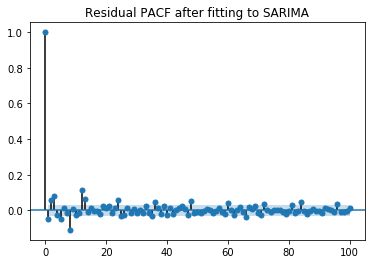

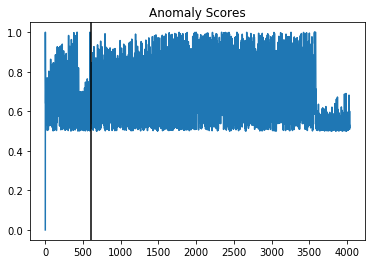

Time:  2.735490083694458
RMSE:  2.8290190061916083


['anomaly_scores/SARIMA_auto/ec2_cpu_utilization_ac20cd']

In [4]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,
                        autoarima=True, 
                        autoarima_season=False, 
                        plot_acf=True, 
                        maxiter=3, 
                        plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


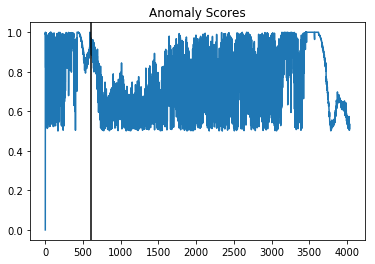

Time:  19.290022373199463
RMSE:  7.245339957583852


['anomaly_scores/Prophet/ec2_cpu_utilization_ac20cd']

In [5]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

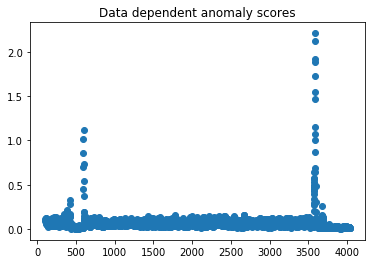

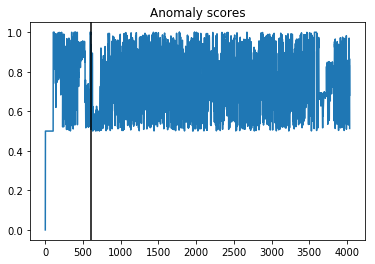

Time:  257.05087327957153


['anomaly_scores/RNN/ec2_cpu_utilization_ac20cd']

In [4]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

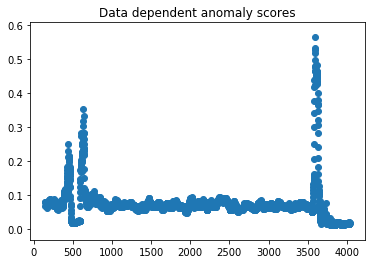

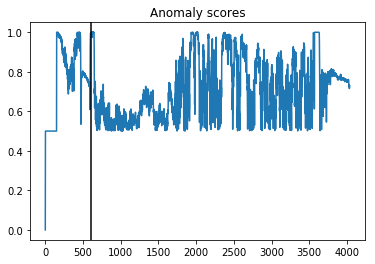

Time:  279.33041501045227


['anomaly_scores/RNN/ec2_cpu_utilization_ac20cd']

In [6]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=50, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

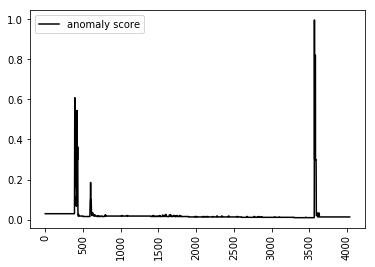

Time:  27.19


['anomaly_scores/HTM/ec2_cpu_utilization_ac20cd']

In [7]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "27.19")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "27.19"}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (58,150 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (120,)         120
donut/p_x_given_z/x_mean/kernel  (100, 120)  12,000
donut/p_x_given_z/x_std/bias     (120,)         120
donut/p_x_given_z/x_std/kernel   (100, 120)  12,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (120, 100)  12,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 10, ETA 26.52s] Learning rate decreased to 

INFO:tensorflow:Restoring parameters from /tmp/tmpfhvk4ixx/variables.dat-100


[Epoch 250/256, Step 250, ETA 0.1888s] Learning rate decreased to 7.525434581650002e-07


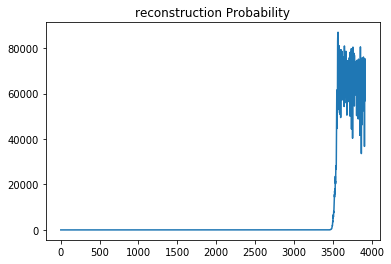

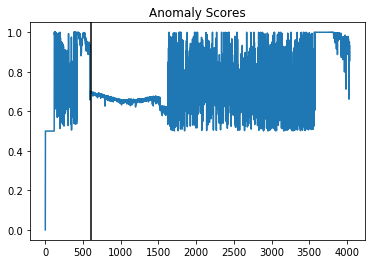

Time:  22.420602560043335


['anomaly_scores/Donut/ec2_cpu_utilization_ac20cd']

In [8]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

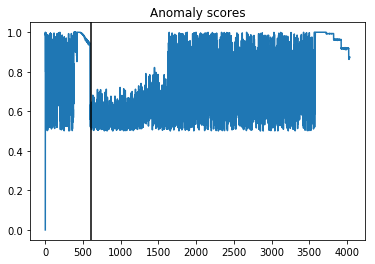

Time:  0.27106404304504395


['anomaly_scores/windowed_gaussian/ec2_cpu_utilization_ac20cd']

In [10]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

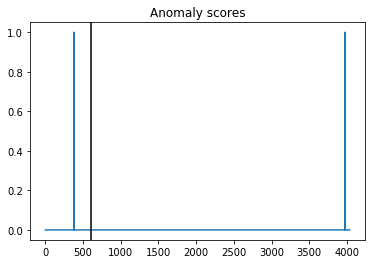

Time:  112.52963256835938


['anomaly_scores/hotsax/ec2_cpu_utilization_ac20cd']

In [11]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [12]:
# no twitter bc no seasonality
# no stl bc no seasonality